## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [4]:
!pip install nlp

In [5]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [6]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [7]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [8]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [9]:
tweets,labels=get_tweet(train)

In [10]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNF>')
tokenizer.fit_on_texts(tweets)

In [13]:
tokenizer.texts_to_sequences([tweets[10]])

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]

In [14]:
tweets[10]

'i feel like i have to make the suffering i m seeing mean something'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

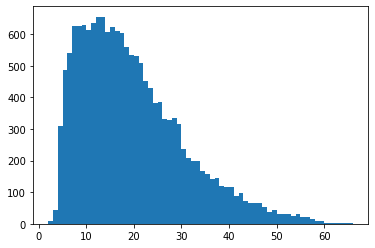

In [15]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [16]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def get_sequences(tokenizer,tweets):
  sequences =  tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=50)
  return padded

In [18]:
padded_train_sequence=get_sequences(tokenizer,tweets)

In [19]:
padded_train_sequence[20]

array([  2,   3, 505,   4, 522, 174, 244, 155, 166,  35, 355, 166,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [20]:
classes=set(labels)
print(classes)

{'joy', 'anger', 'love', 'surprise', 'fear', 'sadness'}


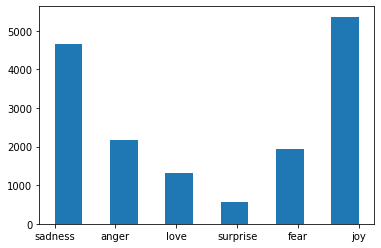

In [21]:
plt.hist(labels,bins=11)
plt.show()

In [22]:
class_to_index=dict((c,i) for i, c in enumerate(classes))
index_to_class=dict({v,k} for k, v  in class_to_index.items())

In [23]:
index_to_class

{0: 'joy', 1: 'anger', 2: 'love', 'fear': 4, 'sadness': 5, 'surprise': 3}

In [24]:
names_to_ids=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels=names_to_ids(labels)

In [26]:
print(train_labels[10])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [27]:
model=tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [29]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [30]:
h=model.fit(padded_train_sequence,train_labels,validation_data=(val_seq,val_labels),epochs=20
            ,callbacks=[
                        
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
            ]
)

Epoch 1/20
500/500 [==============================] - 39s 58ms/step - loss: 1.3941 - accuracy: 0.3874 - val_loss: 1.1698 - val_accuracy: 0.5005
Epoch 2/20
500/500 [==============================] - 27s 54ms/step - loss: 0.7900 - accuracy: 0.6749 - val_loss: 0.6735 - val_accuracy: 0.7395
Epoch 3/20
500/500 [==============================] - 27s 55ms/step - loss: 0.4966 - accuracy: 0.7922 - val_loss: 0.6067 - val_accuracy: 0.7810
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.3508 - accuracy: 0.8714 - val_loss: 0.5007 - val_accuracy: 0.8415
Epoch 5/20
500/500 [==============================] - 27s 54ms/step - loss: 0.2357 - accuracy: 0.9225 - val_loss: 0.4856 - val_accuracy: 0.8590
Epoch 6/20
500/500 [==============================] - 27s 54ms/step - loss: 0.2022 - accuracy: 0.9316 - val_loss: 0.4380 - val_accuracy: 0.8785
Epoch 7/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1544 - accuracy: 0.9496 - val_loss: 0.4462 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

NameError: ignored

In [32]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [45]:
 _ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.4335 - accuracy: 0.8735


In [41]:
i=random.randint(0,len(test_labels)-1)

print('Sentence:',test_tweets[i])
print('Emotions:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:',pred_class)

Sentence: i fancied the terrains there and feel keen to go there again
Emotions: joy
Predicted Emotion: joy


In [50]:
predict_x=model.predict(test_seq) 
pred=np.argmax(predict_x,axis=1)



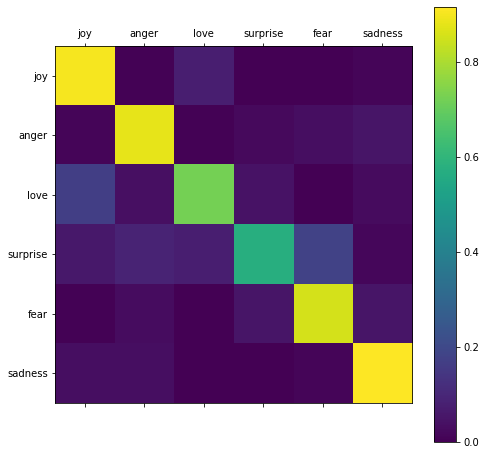

In [57]:

show_confusion_matrix(test_labels,pred,list(classes))

